In [217]:
%store -r after_scaler
%store -r out

In [229]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
#from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier

from tensorflow.keras import layers, Sequential
#from tensorflow import feature_column

In [278]:
df = out.copy()
df.rename(columns = {'Gender':'gender',	
                     'Age':'age', 
                     'Birth Weight':'birth_weight',
                     'Birth Length' : 'birth_length', 
                     'Body Weight' : 'body_weight', 
                     'Body Length' : 'body_length', 
                     'Breastfeeding':'breastfeeding'},
                     inplace = True)

df.head()

,gender,age,birth_weight,birth_length,body_weight,body_length,breastfeeding,Stunting,BMI
0,1,17,3.0,49,31.6,156.2,2,2,20.230474
1,1,16,2.9,49,66.5,156.2,2,1,42.573624
2,2,11,2.8,49,66.5,185.0,2,2,35.945946
3,2,17,2.8,49,78.1,193.0,2,1,40.466321
4,2,10,2.7,49,68.8,151.0,2,2,45.562914


In [279]:
#changing value is binary and drop usless feature
df.gender[df['gender'] == 2] = 0
df.Stunting[df['Stunting'] == 2] = 0
df.BMI = round(df.BMI, 2)
df.drop('breastfeeding', axis=1, inplace=True)

C:\Users\KAZU\AppData\Local\Temp\ipykernel_33224\2483335456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.gender[df['gender'] == 2] = 0
C:\Users\KAZU\AppData\Local\Temp\ipykernel_33224\2483335456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Stunting[df['Stunting'] == 2] = 0


In [280]:
#normalize sckit
df_standard = df[['gender', 'age', 'birth_weight', 'birth_length', 'body_weight', 'body_length', 'BMI']]
labels = df['Stunting']
scaler = StandardScaler()
df_standard = scaler.fit_transform(df_standard)

In [285]:
#labels y
X_train, X_test, y_train, y_test = train_test_split(df_standard, labels, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
X_val.shape

#dosen't separate label
#df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
#df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=1)

(872, 7)

In [289]:
print(len(X_train), len(y_train))
print(len(X_test))
print(len(X_val))

3488 3488
1091
872


In [258]:
#statics for manual normalize
stats_train = df_train.describe()
stats_train.pop('Stunting')
stats_train = stats_train.transpose()
stats_train 

,count,mean,std,min,25%,50%,75%,max
gender,3488.0,0.640768,0.479844,0.00,0.00,1.00,1.00,1.0
age,3488.0,12.460436,3.438114,6.00,10.00,12.00,15.00,22.0
birth_weight,3488.0,2.757540,0.298453,2.00,2.80,2.80,3.00,3.1
birth_length,3488.0,49.104931,0.465499,48.00,49.00,49.00,49.00,50.0
body_weight,3488.0,78.833687,29.389086,20.00,54.90,85.10,101.40,120.0
body_length,3488.0,167.875803,18.997904,125.00,156.20,169.00,185.00,193.0
BMI,3488.0,47.650313,18.861771,10.36,34.46,49.53,62.32,96.0


In [259]:
def labels(x): #if doesnt labels when splitting before
    stunt = x.pop('Stunting')
    stunt = np.array(stunt)

    return stunt

In [260]:
train_y = labels(df_train)
test_y = labels(df_test)
val_y = labels(df_val)
train_y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [261]:
df_train.head()

,gender,age,birth_weight,birth_length,body_weight,body_length,BMI
1439,0,10,2.7,49,85.1,141.0,60.35
44,1,13,3.1,49,54.9,151.0,36.36
566,0,14,2.0,49,54.9,125.0,43.92
3820,1,17,2.9,49,85.1,141.0,60.35
1272,1,14,3.0,49,120.0,161.0,74.53


In [262]:
def norm(x):
    return ((x - stats_train['mean']) / stats_train['std'])

In [263]:
train_norm = norm(df_train)
test_norm = norm(df_test)
val_norm = norm(df_val)
train_norm.head()

,gender,age,birth_weight,birth_length,body_weight,body_length,BMI
1439,-1.335368,-0.715635,-0.192795,-0.225417,0.213219,-1.414672,0.673303
44,0.748643,0.156936,1.147450,-0.225417,-0.814373,-0.888298,-0.598582
566,-1.335368,0.447793,-2.538223,-0.225417,-0.814373,-2.256870,-0.197771
3820,0.748643,1.320364,0.477328,-0.225417,0.213219,-1.414672,0.673303
1272,0.748643,0.447793,0.812389,-0.225417,1.400735,-0.361924,1.425088


In [264]:
def to_array(x):
    df = x.iloc[:,:].values

    return df

In [265]:
train = to_array(train_norm)
test = to_array(test_norm)
val = to_array(val_norm)
train

array([[-1.335368  , -0.71563522, -0.19279464, ...,  0.21321905,
        -1.41467202,  0.67330301],
       [ 0.74864255,  0.15693608,  1.14744992, ..., -0.81437331,
        -0.88829815, -0.59858177],
       [-1.335368  ,  0.44779319, -2.53822263, ..., -0.81437331,
        -2.25687021, -0.19777106],
       ...,
       [-1.335368  , -0.13392102,  0.1422665 , ..., -1.60718463,
         0.90137299, -1.62075511],
       [ 0.74864255,  0.73865029,  0.47732764, ...,  1.24081141,
         0.20655949,  1.03169989],
       [ 0.74864255,  1.02950739,  0.81238878, ..., -0.81437331,
         0.05917481, -0.80375868]])

In [290]:
X_train.shape

(3488, 7)

In [292]:
def build_model():
    model = Sequential()
    model.add(layers.Dense(64, input_shape=(X_train.shape[-1],), activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(7, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return model

In [312]:
encode = LabelEncoder()
encode.fit(y_train)
encode_y = encode.transform(y_train)
estim = []
estim.append(('standardize', StandardScaler()))
estim.append(('mlp', KerasClassifier(model=build_model, 
                                     validation_split=0.2, 
                                     epochs=100, 
                                     batch_size=32, 
                                     verbose=1)))
pipe = Pipeline(estim)
kf = StratifiedKFold(n_splits=10, shuffle=True)
res = cross_val_score(pipe, X_train, encode_y, cv=kf)

Epoch 1/100
88/88 [==============================] - 1s 2ms/step - loss: 0.5827 - accuracy: 0.7057 - val_loss: 0.4938 - val_accuracy: 0.7751
Epoch 2/100
88/88 [==============================] - 0s 1ms/step - loss: 0.4878 - accuracy: 0.7857 - val_loss: 0.4796 - val_accuracy: 0.7794
Epoch 3/100
88/88 [==============================] - 0s 1ms/step - loss: 0.4749 - accuracy: 0.7871 - val_loss: 0.4775 - val_accuracy: 0.7865
Epoch 4/100
88/88 [==============================] - 0s 1ms/step - loss: 0.4696 - accuracy: 0.7860 - val_loss: 0.4775 - val_accuracy: 0.7865
Epoch 5/100
88/88 [==============================] - 0s 1ms/step - loss: 0.4667 - accuracy: 0.7903 - val_loss: 0.4794 - val_accuracy: 0.7865
Epoch 6/100
88/88 [==============================] - 0s 1ms/step - loss: 0.4632 - accuracy: 0.7910 - val_loss: 0.4758 - val_accuracy: 0.7865
Epoch 7/100
88/88 [==============================] - 0s 1ms/step - loss: 0.4622 - accuracy: 0.7878 - val_loss: 0.4780 - val_accuracy: 0.7851
Epoch 8/100
8

Pipeline(steps=[('mlp',
                 KerasClassifier(batch_size=32, epochs=100, model=<function build_model at 0x0000025C63CEFEB0>, validation_split=0.2))])

In [300]:
res.mean()

0.777818397391562

In [304]:
y_pred = cross_val_predict(pipe, X_train, encode_y, cv=kf, verbose=0)
print(confusion_matrix(y_train, y_pred))

Epoch 1/100
79/79 [==============================] - 1s 2ms/step - loss: 0.6951 - accuracy: 0.5755 - val_loss: 0.6413 - val_accuracy: 0.7643
Epoch 2/100
79/79 [==============================] - 0s 1ms/step - loss: 0.5688 - accuracy: 0.7638 - val_loss: 0.4884 - val_accuracy: 0.7691
Epoch 3/100
79/79 [==============================] - 0s 1ms/step - loss: 0.4876 - accuracy: 0.7834 - val_loss: 0.4653 - val_accuracy: 0.7898
Epoch 4/100
79/79 [==============================] - 0s 1ms/step - loss: 0.4765 - accuracy: 0.7845 - val_loss: 0.4637 - val_accuracy: 0.7898
Epoch 5/100
79/79 [==============================] - 0s 1ms/step - loss: 0.4706 - accuracy: 0.7830 - val_loss: 0.4636 - val_accuracy: 0.7930
Epoch 6/100
79/79 [==============================] - 0s 1ms/step - loss: 0.4689 - accuracy: 0.7897 - val_loss: 0.4660 - val_accuracy: 0.7914
Epoch 7/100
79/79 [==============================] - 0s 1ms/step - loss: 0.4667 - accuracy: 0.7913 - val_loss: 0.4654 - val_accuracy: 0.7930
Epoch 8/100
7

In [302]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(encode_y, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1])
    disp.plot(values_format='d');

In [150]:
y_pred.shape

(3488,)

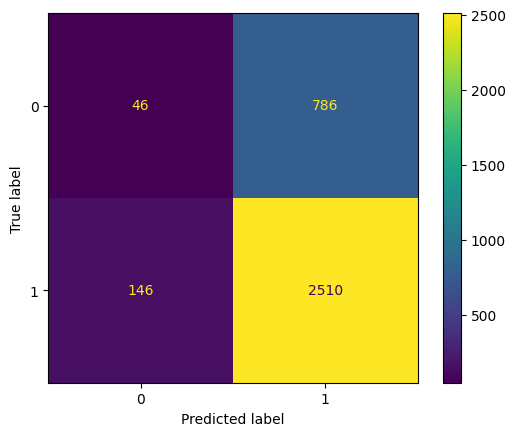

In [303]:
plot_confusion_matrix(encode_y, y_pred, title='Stunting', labels=[0,1])

In [ ]:
#weight sampling keraS
zeros = df[df['Stunting'] == 0]
ones = df[df['Stunting'] == 1]

zero_num = zeros['Stunting'].to_numpy()
one_num = ones['Stunting'].to_numpy()
zero_one = np.concatenate((zero_num, one_num))
unique = np.unique(zero_one)

mass = compute_class_weight(class_weight='balanced', classes=unique, y=zero_one)
weight = dict(zip(np.unique(zero_one), mass))
print(df[df['Stunting'] == 1].shape)
print(df[df['Stunting'] == 0].shape)

#oversampling
'''
over = df[df['Stunting'] == 1]
under = df[df['Stunting'] == 0]

under = under.sample(over.shape[0], replace=True)

print(over.shape)
print(under.shape)
df = pd.concat([over, under])
'''

(4213, 8)
(4213, 8)
